# Wine Quality GAN
## Created 22-Oct-2024 Mark A. Goforth, Ph.D.

### Purpose
This Jupyter notebook is designed to create a GAN Generative Adversarial Network from the Wine Quality dataset. The GAN can be used to generate fake data that looks like the original with the same statistical distributions.

### Description of GANs
GANs can be used to create new data that resembles the training dataset. GANs are made up of two different neural networks that are trained and pit against each other. One network is used for encoding into latent vectors, and the other network is used for decoding.

A GAN is called adversarial because it trains two different networks and pits them against each other. One network generates new data by taking an input data sample and modifying it as much as possible. The other network tries to predict whether the generated data output belongs in the original dataset. In other words, the predicting network determines whether the generated data is fake or real. The system generates newer, improved versions of fake data values until the predicting network can no longer distinguish fake from original.

For additional information about GANs,see https://aws.amazon.com/what-is/gan/, https://realpython.com/generative-adversarial-networks/

### General Steps for Approach
1. Download data
2. Prepare data for training
3. Model Building
4. Model Validation


# Install any necessary python packages

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

import pandas as pd 
import kagglehub

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import psutil
psutil.virtual_memory()

# torch.set_default_dtype(torch.double)
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

svmem(total=17179869184, available=5980020736, percent=65.2, used=10113306624, free=61124608, active=5925363712, inactive=5819056128, wired=4187942912)

# Download latest dataset version

In [2]:
pathstr = kagglehub.dataset_download("adarshde/wine-quality-dataset")
print("Path to dataset files:", pathstr)
df = pd.read_csv(pathstr+'/winequality-dataset_updated.csv')

Path to dataset files: /Users/Mark/.cache/kagglehub/datasets/adarshde/wine-quality-dataset/versions/3


In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.3,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.2,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1999 non-null   float64
 1   volatile acidity      1999 non-null   float64
 2   citric acid           1999 non-null   float64
 3   residual sugar        1999 non-null   float64
 4   chlorides             1999 non-null   float64
 5   free sulfur dioxide   1999 non-null   float64
 6   total sulfur dioxide  1999 non-null   float64
 7   density               1999 non-null   float64
 8   pH                    1999 non-null   float64
 9   sulphates             1999 non-null   float64
 10  alcohol               1999 non-null   float64
 11  quality               1999 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 187.5 KB


In [5]:
# make all the columns the same datatype
df['quality'] = df['quality'].astype('double')

In [6]:
df.describe().T.style.background_gradient(axis=0, cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1999.000000,8.670335,2.240023,4.600000,7.100000,8.000000,9.900000,15.900000
volatile acidity,1999.000000,0.541773,0.180381,0.120000,0.400000,0.530000,0.660000,1.580000
citric acid,1999.000000,0.246668,0.181348,0.000000,0.110000,0.200000,0.385000,1.000000
residual sugar,1999.000000,3.699090,3.290201,0.900000,2.000000,2.300000,3.460000,15.990000
chlorides,1999.000000,0.075858,0.048373,0.010000,0.056000,0.075000,0.086000,0.611000
free sulfur dioxide,1999.000000,20.191096,15.642224,1.000000,9.000000,16.000000,27.000000,72.000000
total sulfur dioxide,1999.000000,52.617809,37.051121,6.000000,24.000000,42.000000,73.000000,289.000000
density,1999.000000,0.996477,0.002110,0.990070,0.995265,0.996600,0.997800,1.003690
pH,1999.000000,3.290140,0.274297,2.340000,3.180000,3.300000,3.420000,4.160000
sulphates,1999.000000,0.949465,0.780523,0.330000,0.560000,0.650000,0.840000,3.990000


# Prepare data for training

In [7]:
sklss = StandardScaler()
npsscale = sklss.fit_transform(df) 
npsscale

array([[-0.61190356,  0.87740187, -1.36053581, ..., -0.49910432,
        -0.92813235, -0.50811687],
       [-0.38863571,  1.87554204, -1.36053581, ..., -0.3453227 ,
        -0.63607409, -0.50811687],
       [-0.38863571,  1.21011526, -1.13990987, ..., -0.3837681 ,
        -0.63607409, -0.50811687],
       ...,
       [ 1.04027849,  1.0992108 , -0.58834503, ..., -0.03775945,
        -0.92813235,  1.08517823],
       [ 2.82642123,  0.43378402, -0.31256261, ..., -0.24280161,
        -1.51224885,  0.28853068],
       [-1.63893564, -0.61980837, -0.64350151, ..., -0.62725567,
        -1.2201906 ,  1.08517823]])

In [8]:
train_dataset = torch.tensor(npsscale)
# train_dataset = train_dataset.type(torch.DoubleTensor)
train_dataset = train_dataset.type(torch.FloatTensor)
train_dataset.T.dtype

torch.float32

In [9]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Build GAN model

In [10]:
# Discriminator
D = nn.Sequential(
    nn.Linear(12, 16),
    nn.LeakyReLU(0.2),
    nn.Linear(16, 8),
    nn.LeakyReLU(0.2),
    nn.Linear(8, 1),
    # nn.Sigmoid()
)

In [11]:
# Generator
latent_dim = 10
G = nn.Sequential(
    nn.Linear(latent_dim, 8),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(8, momentum=0.7),
    nn.Linear(8, 16),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(16, momentum=0.7),
    nn.Linear(16, 12),
    nn.Tanh()
)

In [12]:
# Set device
# torch.set_default_dtype(torch.double)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)
device

device(type='cpu')

In [13]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# ones_ = torch.ones(batch_size, 1, dtype=torch.double).to(device)
# zeros_ = torch.zeros(batch_size, 1, dtype=torch.double).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
    
    for inputs in data_loader:
               
        # reshape and move to GPU
        n = inputs.size(0)
        inputs = inputs.reshape(n, 12).to(device)
        
        # set ones and zeros to correct size
        ones = ones_[:n]
        zeros = zeros_[:n]
                
        ###########################
        ### Train discriminator ###
        ###########################
        
        # real inputs
        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, ones)

        # fake inputs
        noise = torch.randn(n, latent_dim).to(device)
        fake_data = G(noise)
                
        fake_outputs = D(fake_data)
        d_loss_fake = criterion(fake_outputs, zeros)

        # gradient descent step
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #######################
        ### Train generator ###
        #######################
        
        # do it twice:
        for _ in range(2):
            # fake data
            noise = torch.randn(n, latent_dim).to(device)
            fake_data = G(noise)
            fake_outputs = D(fake_data)
        
            # reverse the labels!
            g_loss = criterion(fake_outputs, ones)
        
            # gradient descent step
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
        
        # save losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
    
    ### print and save things ###
    print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
        
    # save fake data to view later
    # print(fake_data)
    

Epoch: 0, d_loss: 0.7187231779098511, g_loss: 0.8857859373092651
Epoch: 1, d_loss: 0.7135429382324219, g_loss: 0.8744978904724121
Epoch: 2, d_loss: 0.7137062549591064, g_loss: 0.8639729022979736
Epoch: 3, d_loss: 0.7114187479019165, g_loss: 0.8508163690567017
Epoch: 4, d_loss: 0.7057802677154541, g_loss: 0.8420674800872803
Epoch: 5, d_loss: 0.7081897258758545, g_loss: 0.8319507837295532
Epoch: 6, d_loss: 0.7076181173324585, g_loss: 0.8247584104537964
Epoch: 7, d_loss: 0.7052566409111023, g_loss: 0.8153784275054932
Epoch: 8, d_loss: 0.7099080085754395, g_loss: 0.8095209002494812
Epoch: 9, d_loss: 0.7051734328269958, g_loss: 0.8036904335021973
Epoch: 10, d_loss: 0.7035582065582275, g_loss: 0.7969843149185181
Epoch: 11, d_loss: 0.7085675597190857, g_loss: 0.7946410179138184
Epoch: 12, d_loss: 0.6983462572097778, g_loss: 0.7902501821517944
Epoch: 13, d_loss: 0.7029210329055786, g_loss: 0.788336455821991
Epoch: 14, d_loss: 0.7015122771263123, g_loss: 0.7868269085884094
Epoch: 15, d_loss: 0.

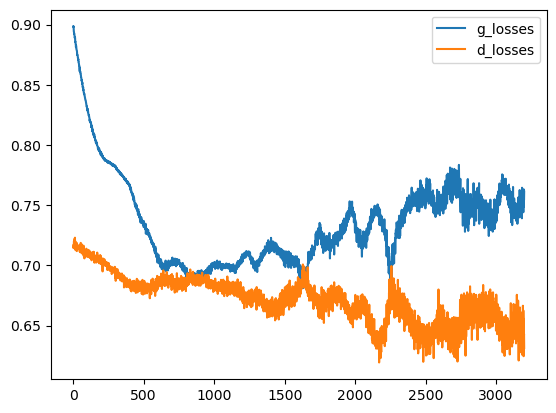

In [15]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

# Model Validation
## View generated fake data and compare with real data original distributions

In [16]:
# transform fake data back into original data ranges
fake_data_transform_back = sklss.inverse_transform(fake_data.detach().numpy())

In [17]:
np.set_printoptions(edgeitems=30,linewidth=100000)
print(fake_data_transform_back)

[[1.06084108e+01 3.61439049e-01 4.27644819e-01 8.79080772e-01 2.78449506e-02 1.17611074e+01 1.56730957e+01 9.95175540e-01 3.21375489e+00 1.06070065e+00 1.19530344e+01 6.82022333e+00]
 [6.43089676e+00 7.22054899e-01 6.53666928e-02 1.66616416e+00 1.24060959e-01 6.33381748e+00 4.22264442e+01 9.94513154e-01 3.56144118e+00 5.95098674e-01 1.09475555e+01 4.46208906e+00]
 [8.43414783e+00 3.61438066e-01 4.26009268e-01 1.03435397e+00 2.76783966e-02 6.61140442e+00 1.55867081e+01 9.94372010e-01 3.33432794e+00 1.03119719e+00 1.20399084e+01 6.88456535e+00]
 [6.43087482e+00 7.22108781e-01 6.53659776e-02 6.78941631e+00 1.24195553e-01 2.19926796e+01 8.95961990e+01 9.94368017e-01 3.40880489e+00 6.66328192e-01 1.16399422e+01 4.51827478e+00]
 [6.44113350e+00 3.61441880e-01 3.88180971e-01 9.36391592e-01 2.75367275e-02 3.41445961e+01 2.57398071e+01 9.94367480e-01 3.10609674e+00 4.99392778e-01 1.20407448e+01 6.87595081e+00]
 [1.09027061e+01 3.88094038e-01 4.13952827e-01 9.11845922e-01 9.78919342e-02 4.901557

In [18]:
pd.set_option('display.max_columns', 200)
index = ['Row'+str(i) for i in range(1, len(fake_data_transform_back)+1)]
dffake = pd.DataFrame(data=fake_data_transform_back, index=index, columns=df.columns )
print(dffake)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
Row1       10.608411          0.361439     0.427645        0.879081   
Row2        6.430897          0.722055     0.065367        1.666164   
Row3        8.434148          0.361438     0.426009        1.034354   
Row4        6.430875          0.722109     0.065366        6.789416   
Row5        6.441133          0.361442     0.388181        0.936392   
...              ...               ...          ...             ...   
Row75       6.430892          0.722108     0.065366        4.990491   
Row76      10.894891          0.363085     0.427961        0.658216   
Row77      10.791627          0.722109     0.065375        6.933640   
Row78       6.443532          0.361600     0.427855        3.302226   
Row79      10.879716          0.361439     0.427898        1.161572   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Row1    0.027845            11.761107             15.673096  0.995176   
R

## fake generated data

In [19]:
dffake.describe().T.style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
fixed acidity,79.000000,8.393890,2.043230,6.430872,6.432018,7.250790,10.851866,10.909798
volatile acidity,79.000000,0.536189,0.169813,0.361438,0.361908,0.456217,0.721767,0.722109
citric acid,79.000000,0.256786,0.169461,0.065366,0.065654,0.337430,0.427357,0.427971
residual sugar,79.000000,3.007764,2.370422,0.553515,0.903755,2.082477,5.311619,6.988448
chlorides,79.000000,0.086191,0.037570,0.027505,0.045713,0.101336,0.120486,0.124196
free sulfur dioxide,79.000000,20.740623,13.308418,4.563985,5.527343,21.888752,34.668217,35.829395
total sulfur dioxide,79.000000,53.777435,33.090622,15.578064,16.460245,64.416931,88.855415,89.659660
density,79.000000,0.996553,0.001936,0.994367,0.994379,0.997329,0.998581,0.998586
pH,79.000000,3.306351,0.213625,3.015913,3.072547,3.293931,3.541996,3.564362
sulphates,79.000000,0.796907,0.428316,0.177796,0.482847,0.743149,1.061586,1.729792


## original real data distributions

In [20]:
df.describe().T.style.background_gradient(axis=0, cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1999.000000,8.670335,2.240023,4.600000,7.100000,8.000000,9.900000,15.900000
volatile acidity,1999.000000,0.541773,0.180381,0.120000,0.400000,0.530000,0.660000,1.580000
citric acid,1999.000000,0.246668,0.181348,0.000000,0.110000,0.200000,0.385000,1.000000
residual sugar,1999.000000,3.699090,3.290201,0.900000,2.000000,2.300000,3.460000,15.990000
chlorides,1999.000000,0.075858,0.048373,0.010000,0.056000,0.075000,0.086000,0.611000
free sulfur dioxide,1999.000000,20.191096,15.642224,1.000000,9.000000,16.000000,27.000000,72.000000
total sulfur dioxide,1999.000000,52.617809,37.051121,6.000000,24.000000,42.000000,73.000000,289.000000
density,1999.000000,0.996477,0.002110,0.990070,0.995265,0.996600,0.997800,1.003690
pH,1999.000000,3.290140,0.274297,2.340000,3.180000,3.300000,3.420000,4.160000
sulphates,1999.000000,0.949465,0.780523,0.330000,0.560000,0.650000,0.840000,3.990000
